In [1]:
from scipy.io import loadmat
import numpy as np 
import matplotlib.pyplot as plt
import time
from scipy.io import loadmat
from scipy.sparse.linalg import svds, bicg, inv, LinearOperator
from scipy.sparse import diags
from scipy.linalg import pinv

# 1 X-ray tomography

In [2]:
H = loadmat('data/H.mat')['H']
x = loadmat('data/x.mat')['x']
G = loadmat('data/G.mat')['G']

In [3]:
hx = H@x
y = hx + np.random.normal(size = hx.shape, scale=1)

In [4]:
y_view = y.reshape((90,180), order='F')
x_view = x.reshape((90,90), order='F')

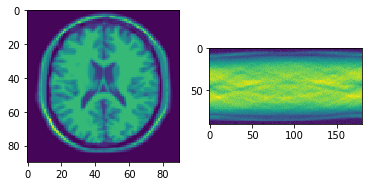

In [5]:
fg , ax = plt.subplots(1,2)
ax[0].imshow(x_view)
ax[1].imshow(y_view)

# 2 Optimization problem

Given that $$\left(\forall x \in \mathbb{R}^{N}\right) \quad f(x)=\frac{1}{2}\|H x-y\|^{2}+\lambda r(x)$$

With, $$\left(\forall x \in \mathbb{R}^{N}\right) \quad r(x)=\sum_{n=1}^{2 N} \psi\left([G x]^{(n)}\right)$$

With, $$\left(\forall u \in \mathbb{R}\right) \quad \psi(u)=\sqrt{1+\frac{u^{2}}{\delta^{2}}}$$

---

One has :$$\left(\forall x \in \mathbb{R}^{N}\right) \quad \nabla f=H^{\top} H x - H^{\top} y + \lambda \nabla r(x)$$
$$\left(\forall x \in \mathbb{R}^{N}\right) \quad \lambda\nabla r = \lambda G^{\top}\psi^{\prime}(G x)$$
with $$\psi^{\prime}(u)=\frac{u}{\delta^{2} \sqrt{1+\frac{u^{2}}{\delta^{2}}}}$$ applied to each component of $G x$.

In [6]:
def r(x):
    return np.sum(np.sqrt(1 + G.dot(x) ** 2 / ( delta ** 2 )))

def f(x, y, lambda_): 
    return(1/2 * np.linalg.norm(H@x - y, ord=2) + lambda_ * r(x))

In [7]:
lambda_ , delta = 0.13, 0.02

In [8]:
def grad_f(x): 
    return(H.T @ (H @ x) - H.T @ y + lambda_ * G.T @ grad_psi(G @ x))

def grad_psi(u, delta=delta): 
    return(u / ( delta ** 2 * np.sqrt(1 + u ** 2 / ( delta ** 2 ))))

def h(x): 
    
    return(f(x_n) + np.dot(grad_f(x_n), x - x_n) + 1/2 * np.sqrt(np.dot(x - x_n, A @ (x - x_n))))

Moreover, given that :$$\nabla f=H^{\top} H x-H^{\top} y+\lambda G^{\top} \Psi^{\prime}(G x)$$
One has, 
$$\left\|\nabla f(x_{1})-\nabla f(x_{2})\right\| = \left\|H^{\top} H (x_{1}-x_{2}) + \lambda G^{\top} \psi^{\prime}(G x_{1}) - \psi^{\prime}(G x_{2}) \right\|$$
Thus with $\lambda>0$ and using the triangle inequality, 
$$\left\|\nabla f(x_{1})-\nabla f(x_{2})\right\|\leq \left\|H^{\top} H (x_{1}-x_{2})\right\| + \lambda \left\|G^{\top}\psi^{\prime}(G x_{1}) - G^{\top}\psi^{\prime}(G x_{2})\right\|$$
$$\left\|\nabla f(x_{1})-\nabla f(x_{2})\right\|\leq \left\|H^{\top} H (x_{1}-x_{2})\right\| + \lambda \left\|G\right\| \left\|\psi^{\prime}(G x_{1}) - \psi^{\prime}(G x_{2})\right\|$$
Then by the fact that $$\left(\forall u \in \mathbb{R}\right) \quad \left\|\psi^{\prime}(u)\right\|=\left\|\frac{u}{\delta^{2} \sqrt{1+\frac{u^{2}}{\delta^{2}}}}\right\| \leq \left\|\frac{u}{\delta^{2}}\right\|$$ we know that $\frac{1}{\delta^{2}}$ is a Lipschitz constant of $\psi^{\prime}$.
And thus, $$\left\|\nabla f(x_{1})-\nabla f(x_{2})\right\| \leq \left\|H\right\|^{2} \left\|x_{1}-x_{2}\right\| + \lambda \left\|G\right\| \frac{1}{\delta^{2}} \left\|G x_{1} - G x_{2}\right\|$$
And finally : $$\left\|\nabla f(x_{1})-\nabla f(x_{2})\right\| \leq \left(\left\|H\right\|^{2}+ \frac{\lambda}{\delta^{2}} \left\|G\right\|^{2}\right) \left\|x_{1} - x_{2}\right\|$$

Thus, $L=\|H\|^{2}+\left(\lambda / \delta^{2}\right)\|G\|^{2}$ is a Lipschitz constant of $\nabla f$, which for $(\lambda, \delta)=(0.13,0.02)$ gives $L=1.809e+04$.

Detailed computation of L in this case :

In [9]:
def lipschitz_constant(G,H, lambda_=0.13, delta=0.02):
    _, singular_value_G, _ = svds(G)
    _, singular_value_H, _ = svds(H)
    return(max(singular_value_H) ** 2 + (lambda_ / (delta ** 2 )) * (max(singular_value_G)**2))

In [10]:
print("The lipschitz constant of the gradient of f is : {:.3e}".format(lipschitz_constant(G,H)))

The lipschitz constant of the gradient of f is : 1.809e+04


# 3 Optimization algorithms
## 3.1 Gradient Descent Algorithm 

In [11]:
M, N = 90 * 180, 90 * 90 
x_0 = np.zeros((N,1))

Error : 2.4844e+01 | value of f : 2619.9613 | rec_error : 18.7717
Error : 4.9668e-01 | value of f : 3028.6944 | rec_error : 10.8328
Error : 2.1406e-01 | value of f : 3551.4999 | rec_error : 8.6575
Error : 1.3828e-01 | value of f : 3956.2888 | rec_error : 7.3581
Error : 1.0148e-01 | value of f : 4271.6017 | rec_error : 6.4509
Error : 7.7898e-02 | value of f : 4520.3230 | rec_error : 5.7899
Error : 6.1385e-02 | value of f : 4718.5182 | rec_error : 5.2985
Error : 4.9353e-02 | value of f : 4877.8572 | rec_error : 4.9282
Error : 4.0349e-02 | value of f : 5007.0074 | rec_error : 4.6465
Error : 3.3471e-02 | value of f : 5112.4677 | rec_error : 4.4305
Error : 2.8129e-02 | value of f : 5199.1499 | rec_error : 4.2641
Error : 2.3923e-02 | value of f : 5270.8091 | rec_error : 4.1354
Error : 2.0570e-02 | value of f : 5330.3584 | rec_error : 4.0357
Error : 1.7868e-02 | value of f : 5380.0876 | rec_error : 3.9583
Error : 1.5667e-02 | value of f : 5421.8138 | rec_error : 3.8984
Error : 1.3856e-02 | va

Text(0.5, 1.0, 'Reconstruction result, Gradient Descent algorithm, lr=5.527e-05,\nlambda_=1.300e-01 , delta=2.000e-02, standardized_error=1.1275e-01')

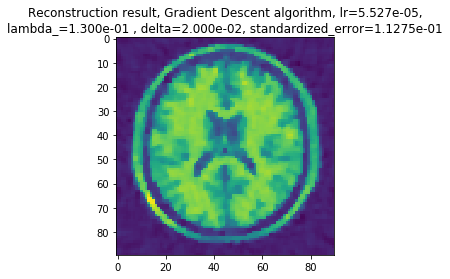

In [88]:
learning_rate = 1/lipschitz_constant(G,H)
def grad_desc(lambda_=lambda_, delta=delta, learning_rate=1e-4, eps=1e-6, max_iter=1000,
              stopping='standard', error_type='norm', records=True):
    history = []
    x_n = x_0.copy()
    converged = False
    itr = 0
    begin = time.time()
    while itr < max_iter and not converged : 
        grad = grad_f(x_n)
        x_n1 = x_n - learning_rate * grad
        if error_type=='SNR':
            error = 20*np.log10(np.linalg.norm(x.flatten(), ord=2)/np.linalg.norm((x-x_n1).flatten(), ord=2))
        else:
            #error = np.sum(np.abs(x_n1 - x_n))
            error = np.linalg.norm((x_n1 - x_n).flatten(), ord=2)
        history.append([error, f(x_n1, y, lambda_)])
        if stopping=='gradient':
            criterion = np.linalg.norm(grad_f(x_n1).flatten(), ord=2) <= np.sqrt(N)*1e-4
        else:
            criterion = error < eps * np.linalg.norm(x_n.flatten(), ord=2) #np.sum(np.abs(x_n))
        if criterion:
            converged = True
        if itr % 10 == 0 and records==True: 
            print('Error : {0:.4e} | value of f : {1:.4f} | rec_error : {2:.4f}'.format(error, f(x_n1, y, 0.13),
                                                                np.linalg.norm((x_n1 - x).flatten(), ord=2)))
        x_n = x_n1.copy()
        itr+=1

    end = time.time()
    if records==True:
        print('It took {0} iterations and {1:.2f} seconds to converge.'.format(itr,end-begin))
    
    return x_n, error, history
    
x_rec_GD, _, history_GD = grad_desc(learning_rate=1/lipschitz_constant(G,H))
error_GD = np.linalg.norm((x - x_rec_GD).flatten(), ord=2)/np.linalg.norm(x.flatten(), ord=2)
x_rec_GD_view = x_rec_GD.reshape((90,90), order='F')
fg, ax = plt.subplots(1,1)
ax.imshow(x_rec_GD_view)
ax.set_title('Reconstruction result, Gradient Descent algorithm, lr={0:.3e},'.format(learning_rate)
             +'\nlambda_={0:.3e} , delta={1:.3e}, standardized_error={2:.4e}'.format(lambda_, delta, error_GD))

>According to the records of the successive errors (difference from one iteration to another), this method converges. Surprisingly, we observe that the value of f increases with the iterations, as well as the reconstruction error which decreases to 3.7328 and then increases... Thus, we will need to try out other approaches !

## 3.2 MM quadratic algorithm

For every $y \in \mathbb{R}^{N}$ we will look for a self-adjoint operator A such that :$$(\forall x \in \mathbb{R}^{N}) \quad h(x, y)=f(y)+\langle\nabla f(y) | x-y\rangle+\frac{1}{2}\|x-y\|_{A(y)}^{2}$$ is a majorant function of f at y.

We will construct $\Delta$ such that :$$(\forall x \in \mathbb{R}^{N}) \quad \Delta=\operatorname{diag}\left\{\frac{\psi^{\prime}(x_{i})}{x_{i}}\right\}_{i \in \{1, \ldots, N\}}$$ because $\psi(\sqrt{.})$ is concave, $\psi$ is positive and $\lim_{u \to 0^{+}} \frac{\psi(u)}{u}$ is finite.

And then we choose A as : $$(\forall x \in \mathbb{R}^{N}) \quad A(x)=H^{\top}H + \lambda G^{\top} \Delta(G x) G$$

In [71]:
diags((grad_psi(x)/x).flatten()).tocsc()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


<8100x8100 sparse matrix of type '<class 'numpy.float64'>'
	with 8100 stored elements in Compressed Sparse Column format>

In [72]:
def big_delta(x, delta, eps = 1e-10):
    return diags((grad_psi(x, delta)/(x+eps)).flatten()).tocsc()

Error : 3.6496e+01 | value of f : 14506.3030 | rec_error : 9.2512
Error : 5.4580e-02 | value of f : 5709.8817 | rec_error : 3.9720
Error : 9.5893e-03 | value of f : 5694.2745 | rec_error : 4.0062
Error : 2.3877e-03 | value of f : 5692.3628 | rec_error : 4.0116
Error : 6.6893e-04 | value of f : 5691.9827 | rec_error : 4.0128
Error : 2.0109e-04 | value of f : 5691.8910 | rec_error : 4.0130
Error : 6.4124e-05 | value of f : 5691.8667 | rec_error : 4.0131
It took 67 iterations and 35.77 seconds to converge.


Text(0.5, 1.0, 'Reconstruction result, MM_quad algorithm, lr=5.527e-05,\nlambda_=1.300e-01 , delta=2.000e-02, error=1.1371e-01')

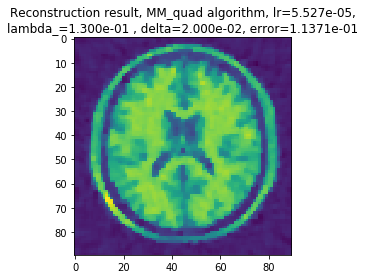

In [73]:
def MM_quad(lambda_=lambda_, delta=delta, eps=1e-6, max_iter=1000,
            stopping='standard', error_type='norm', records=True):
    history = []
    x_n = x_0.copy()
    converged = False
    itr = 0
    begin = time.time()
    while itr < max_iter and not converged : 
        grad = grad_f(x_n)
        A_x = lambda x : (H.T.dot(H.dot(x)) + lambda_ * G.T.dot(big_delta(G.dot(x_n), delta).dot(G.dot(x))))
        A = LinearOperator((N,N),matvec = A_x, rmatvec = A_x)
        x_n1 = x_n - bicg(A, grad, tol=1e-3)[0].reshape(-1, 1)
        if error_type=='SNR':
            error = 20*np.log10(np.linalg.norm(x.flatten(), ord=2)/np.linalg.norm((x-x_n1).flatten(), ord=2))
        else:
            #error = np.sum(np.abs(x_n1 - x_n))
            error = np.linalg.norm((x_n1 - x_n).flatten(), ord=2)
        history.append([error, f(x_n1, y, lambda_)])
        if stopping=='gradient':
            criterion = np.linalg.norm(grad_f(x_n1).flatten(), ord=2) <= np.sqrt(N)*1e-4
        else:
            criterion = error < eps * np.linalg.norm(x_n.flatten(), ord=2) #np.sum(np.abs(x_n))
        if criterion:
            converged = True
        if itr % 10 == 0 and records==True: 
            print('Error : {0:.4e} | value of f : {1:.4f} | rec_error : {2:.4f}'.format(error, f(x_n1, y, 0.13),
                                                                np.linalg.norm((x_n1 - x).flatten(), ord=2)))
        x_n = x_n1.copy()
        itr+=1
        
    end = time.time()
    if records==True:
        print('It took {0} iterations and {1:.2f} seconds to converge.'.format(itr,end-begin))

    return x_n, error, history
    
x_rec_MM, _, history_MM = MM_quad()
rec_error_MM = np.linalg.norm((x - x_rec_MM).flatten(), ord=2)/np.linalg.norm(x.flatten(), ord=2)
x_rec_MM_view = x_rec_MM.reshape((90,90), order='F')
fg, ax = plt.subplots(1,1)
ax.imshow(x_rec_MM_view)
ax.set_title('Reconstruction result, MM_quad algorithm, lr={0:.3e},'.format(learning_rate)
             +'\nlambda_={0:.3e} , delta={1:.3e}, error={2:.4e}'.format(lambda_, delta, rec_error_MM))

>Here the algorithm also converges according to the records of the successive errors. In this case the value of the function f to minimize decreases along the iterations. However, the reconstruction error decreases dramatically at first step, and then doesn't evolve that much... We will try out other approaches to speed up convergence.

## 3.3 3MG algorithm

We will minimize the quadratic majorant function using the subspace spanned by :$$(\forall k \in \mathbb{N}) \quad D_{k}=\left[-\nabla f\left(x_{k}\right) \quad | \quad x_{k}-x_{k-1}\right]$$
Thus, at iterate k, one has : $$(\forall k \in \mathbb{N}) \quad x_{k+1}=x_{k}+D_{k} u_{k}$$
with $$(\forall k \in \mathbb{N}) \quad u_{k}=-\left(D_{k}^{\top} A\left(x_{k}\right) D_{k}\right)^{\dagger}\left(D_{k}^{\top} \nabla f\left(x_{k}\right)\right)$$
with $M^{\dagger}$ the pseudo inverse of M (obtained using np.linalg.pinv($\Delta$).
Which can be rewritten : $$(\forall k \in \mathbb{N}) \quad u_{k}=-\left((H D_{k})^{\top} (H D_{k}) + \lambda (G D_{k})^{\top} \Delta\left(G x_{k}\right) (G D_{k}) \right)^{\dagger}\left(D_{k}^{\top} \nabla f\left(x_{k}\right)\right)$$

Error : 2.9273e+01 | value of f : 2549.8064 | rec_error : 17.9662
Error : 4.8170e-01 | value of f : 3816.3697 | rec_error : 7.8214
Error : 2.4254e-01 | value of f : 4517.3221 | rec_error : 5.8182
Error : 1.4285e-01 | value of f : 4927.4581 | rec_error : 4.8318
Error : 9.2166e-02 | value of f : 5177.6424 | rec_error : 4.3132
Error : 6.3751e-02 | value of f : 5335.9535 | rec_error : 4.0318
Error : 4.6711e-02 | value of f : 5439.1027 | rec_error : 3.8777
Error : 3.5883e-02 | value of f : 5508.1351 | rec_error : 3.7946
Error : 2.8633e-02 | value of f : 5555.5616 | rec_error : 3.7525
Error : 2.3556e-02 | value of f : 5588.9319 | rec_error : 3.7344
Error : 1.9835e-02 | value of f : 5612.9137 | rec_error : 3.7307
Error : 1.6993e-02 | value of f : 5630.4861 | rec_error : 3.7355
Error : 1.4759e-02 | value of f : 5643.5795 | rec_error : 3.7454
Error : 1.2961e-02 | value of f : 5653.4732 | rec_error : 3.7581
Error : 1.1483e-02 | value of f : 5661.0410 | rec_error : 3.7723
Error : 1.0243e-02 | val

Text(0.5, 1.0, 'Reconstruction result, 3MG algorithm, lr=5.527e-05,\nlambda_=1.300e-01 , delta=2.000e-02, error=1.1365e-01')

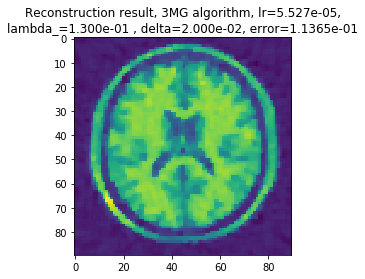

In [74]:
def MMMG(lambda_=lambda_, delta=delta, eps=1e-6, max_iter=1000, 
         stopping='standard', error_type='norm', records=True):
    history = []
    x_n = x_0.copy()
    converged = False
    itr = 0
    begin = time.time()
    while itr < max_iter and not converged : 
        grad = grad_f(x_n)
        if itr==0:
            D_n = -grad
        else:
            D_n = np.concatenate((-grad, x_n - x_old), axis=1)
        D_n = D_n.reshape(N,-1)
        matrix_shape = D_n.shape[1]
        sub_A_x = lambda x : ((H@D_n).T.dot((H@D_n)) + lambda_ * (G@D_n).T.dot(big_delta(G.dot(x_n),
                                                                                    delta).dot((G@D_n)))).dot(x)
        A = LinearOperator((matrix_shape,matrix_shape),matvec = sub_A_x, rmatvec = sub_A_x)
        b = D_n.T@grad
        x_n1 = x_n - D_n@bicg(A, b, tol=1e-3)[0].reshape(-1, 1)
        if error_type=='SNR':
            error = 20*np.log10(np.linalg.norm(x.flatten(), ord=2)/np.linalg.norm((x-x_n1).flatten(), ord=2))
        else:
            #error = np.sum(np.abs(x_n1 - x_n))
            error = np.linalg.norm((x_n1 - x_n).flatten(), ord=2)
        history.append([error, f(x_n1, y, lambda_)])
        if stopping=='gradient':
            criterion = np.linalg.norm(grad_f(x_n1).flatten(), ord=2) <= np.sqrt(N)*1e-4
        else:
            criterion = error < eps * np.linalg.norm(x_n.flatten(), ord=2) #np.sum(np.abs(x_n))
        if criterion:
            converged = True
        if itr % 10 == 0 and records==True: 
            print('Error : {0:.4e} | value of f : {1:.4f} | rec_error : {2:.4f}'.format(error, f(x_n1, y, 0.13),
                                                                np.linalg.norm((x_n1 - x).flatten(), ord=2)))
        x_old = x_n.copy()
        x_n = x_n1.copy()
        itr+=1
        
    end = time.time()
    if records==True:
        print('It took {0} iterations and {1:.2f} seconds to converge.'.format(itr,end-begin))

    return x_n, error, history
    
x_rec_MMMG, _, history_MMMG = MMMG()
rec_error_MMMG = np.linalg.norm((x - x_rec_MMMG).flatten(), ord=2)/np.linalg.norm(x.flatten(), ord=2)
x_rec_MMMG_view = x_rec_MMMG.reshape((90,90), order='F')
fg, ax = plt.subplots(1,1)
ax.imshow(x_rec_MMMG_view)
ax.set_title('Reconstruction result, 3MG algorithm, lr={0:.3e},'.format(learning_rate)
             +'\nlambda_={0:.3e} , delta={1:.3e}, error={2:.4e}'.format(lambda_, delta, rec_error_MMMG))

>Here as well the algorithm converges but it converges very slowly... The function to minimize increases globally and is a little instable. The reconstruction error doesn't evolve dramatically. This method is either not properly implemented or the approach itself of a Memory Gradient Subspace strategy isn't a good one. This might explain the existence of other approaches such as Supermemory Gradient, Gradient Subspace, Nemirovski Subspace, Sequential Subspace and Quasi-Newton Subspace.

## 3.4 Block-coordinate MM quadratic algorithm

We will consider here the following selection for the block index j:$$(\forall k \in \mathbb{N}) \quad j=\operatorname{mod} (k-1, J)+1$$
Then the pixels indexes $n \in \mathbb{J}_{j}$ are updated, with :$$\mathbb{J}_{j}=\left\{N_{j}(j-1)+1, \ldots, j N_{j}\right\}$$

Error : 8.4001e+01 | value of f : 24613.2454 | rec_error : 89.9830
Error : 4.4877e+01 | value of f : 127085.2077 | rec_error : 167.1404
Error : 1.7578e+01 | value of f : 50005.7377 | rec_error : 73.1562
Error : 9.8792e+00 | value of f : 26083.6556 | rec_error : 39.8421
Error : 5.3986e+00 | value of f : 15024.6808 | rec_error : 21.1364
Error : 3.2694e+00 | value of f : 9507.6895 | rec_error : 10.8852
Error : 1.8852e+00 | value of f : 7035.2214 | rec_error : 6.1493
Error : 7.2718e-01 | value of f : 6078.8233 | rec_error : 4.4445
Error : 2.5215e-01 | value of f : 5809.2024 | rec_error : 4.0603
Error : 1.0303e-01 | value of f : 5743.6472 | rec_error : 3.9810
Error : 5.9462e-02 | value of f : 5721.3971 | rec_error : 3.9684
Error : 3.8406e-02 | value of f : 5710.2929 | rec_error : 3.9673
Error : 3.3519e-02 | value of f : 5704.9765 | rec_error : 3.9697
Error : 1.9324e-02 | value of f : 5701.3012 | rec_error : 3.9747
Error : 1.5244e-02 | value of f : 5699.2693 | rec_error : 3.9804
Error : 1.52

Text(0.5, 1.0, 'Reconstruction result, Block Coordinate algorithm, lr=5.527e-05,\nlambda_=1.300e-01 , delta=2.000e-02, error=1.1370e-01')

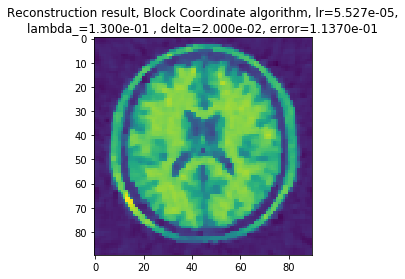

In [75]:
def BCMM(nb_blocks=6, lambda_=lambda_, delta=delta, eps=1e-6, max_iter=1000, 
         stopping='standard', error_type='norm', records=True):
    history = []
    x_n = x_0.copy()
    N_j = N//nb_blocks
    block_size = [N_j for _ in range(nb_blocks)]
    if N_j*nb_blocks != N:
        block_size += [N - nb_blocks*N_j]
    converged = False
    itr = 0
    begin = time.time()
    while itr < max_iter and not converged : 
        block_idx = itr%(nb_blocks)
        N_j = block_size[block_idx]
        H_j = H[:,N_j*block_idx:(block_idx+1)*N_j]
        G_j = G[:,N_j*block_idx:(block_idx+1)*N_j]
        x_n_j = x_n[N_j*block_idx:(block_idx+1)*N_j]
        grad = grad_f(x_n)[N_j*block_idx:(block_idx+1)*N_j]
        A_x = lambda x : (H_j.T.dot(H_j.dot(x)) + lambda_ * G_j.T.dot(big_delta(G_j.dot(x_n_j),
                                                                                delta).dot(G_j.dot(x))))
        A = LinearOperator((N_j,N_j),matvec = A_x, rmatvec = A_x)
        mask = np.zeros(x_n.shape)
        mask[N_j*block_idx:(block_idx+1)*N_j] = bicg(A, grad, tol=1e-3)[0].reshape(-1, 1)
        x_n1 = x_n - mask
        if error_type=='SNR':
            error = 20*np.log10(np.linalg.norm(x.flatten(), ord=2)/np.linalg.norm((x-x_n1).flatten(), ord=2))
        else:
            #error = np.sum(np.abs(x_n1 - x_n))
            error = np.linalg.norm((x_n1 - x_n).flatten(), ord=2)
        history.append([error, f(x_n1, y, lambda_)])
        if stopping=='gradient':
            criterion = np.linalg.norm(grad_f(x_n1).flatten(), ord=2) <= np.sqrt(N)*1e-4
        else:
            criterion = error < eps * np.linalg.norm(x_n.flatten(), ord=2) #np.sum(np.abs(x_n))
        if criterion:
            converged = True
        if itr % 10 == 0 and records==True: 
            print('Error : {0:.4e} | value of f : {1:.4f} | rec_error : {2:.4f}'.format(error, f(x_n1, y, 0.13),
                                                                np.linalg.norm((x_n1 - x).flatten(), ord=2)))
        x_n = x_n1.copy()
        itr+=1
        
    end = time.time()
    if records==True:
        print('It took {0} iterations and {1:.2f} seconds to converge.'.format(itr,end-begin))

    return x_n, error, history
    
x_rec_BCMM, _, history_BCMM = BCMM(9)
rec_error_BCMM = np.linalg.norm((x - x_rec_BCMM).flatten(), ord=2)/np.linalg.norm(x.flatten(), ord=2)
x_rec_BCMM_view = x_rec_BCMM.reshape((90,90), order='F')
fg, ax = plt.subplots(1,1)
ax.imshow(x_rec_BCMM_view)
ax.set_title('Reconstruction result, Block Coordinate algorithm, lr={0:.3e},'.format(learning_rate)
             +'\nlambda_={0:.3e} , delta={1:.3e}, error={2:.4e}'.format(lambda_, delta, rec_error_BCMM))

>This algorithm also converges and is pretty fast. The value of the function f to minimize decreases and the reconstruction error decreases dramatically and then stays on a same level for the rest of the algorithm.

Let's try to find the best value for J=nb_blocks :

**Using a grid search :**

Text(0.5, 1.0, 'Reconstruction result, MM quadratic algorithm, lr=5.527e-05,\nnb_blocks=1.000e+00 , error=1.1371e-01\n1000 iterations, 105.304 seconds')

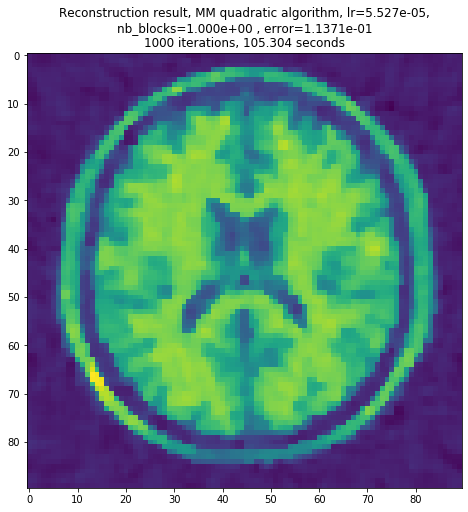

In [89]:
fg, ax = plt.subplots(1,1,figsize=(8,8))
grid = [1,2,3,5,6,9]
best_error = np.inf
best_J = 0
best_x_rec = 0
best_nb_itr = 0
best_exec_time = 0
for J in grid:
    beg = time.time()
    x_rec, _, history = BCMM(nb_blocks=J, max_iter=1000, records=False, error_type='SNR')
    end = time.time()
    nb_itr = len(history)
    exec_time = end - beg
    rec_error = np.linalg.norm((x - x_rec).flatten(), ord=2)/np.linalg.norm(x.flatten(), ord=2)
    if rec_error < best_error:
        best_J = J
        best_error = rec_error
        best_x_rec = x_rec
        best_nb_itr = nb_itr
        best_exec_time = exec_time

        
x_rec_view = best_x_rec.reshape((90,90), order='F')
ax.imshow(x_rec_view)
ax.set_title('Reconstruction result, MM quadratic algorithm, lr={0:.3e},'.format(learning_rate)
             +'\nnb_blocks={0:.3e} , error={1:.4e}'.format(best_J, best_error)
             +'\n{0} iterations, {1:.3f} seconds'.format(best_nb_itr, best_exec_time))

**Using a golden section search :**

In [67]:
def golden_section_search(function, x, nb_blocks_range, tol=1e-8, it_max=100, name='MM_quad'):
    nb_blocks0, nb_blocks3 = nb_blocks_range
    error = []
    nb_blocks = []
    golden_section_gamma = [(3 - np.sqrt(5))/2 , (np.sqrt(5)-1)/2]
    best_nb_blocks = {}
    it = 0
    converged = False
    while not converged and (it < it_max):
        it=it+1
        nb_blocks1 = int(nb_blocks0 + golden_section_gamma[0] * (nb_blocks3 - nb_blocks0))
        nb_blocks2 = int(nb_blocks0 + golden_section_gamma[1] * (nb_blocks3 - nb_blocks0))

        x_rec_1, _, _ = function(nb_blocks1)
        rec_error1 = np.linalg.norm(x-x_rec_1, ord='fro')/np.linalg.norm(x, ord='fro')
        nb_blocks.append(nb_blocks1)
        error.append(rec_error1)

        x_rec_2, _, _ = function(nb_blocks2)
        rec_error2 = np.linalg.norm(x-x_rec_2, ord='fro')/np.linalg.norm(x, ord='fro')
        nb_blocks.append(nb_blocks2)
        error.append(rec_error2)

        converged = (abs(rec_error2 - rec_error1)<tol)
        if rec_error1 < rec_error2 : 
            nb_blocks0, nb_blocks3 = nb_blocks0, nb_blocks2
        else: 
            nb_blocks0, nb_blocks3 = nb_blocks1, nb_blocks3
    if converged :
        print('optimal value reached for : nb_blocks = {:.2e}'.format(nb_blocks1))
    end = time.time()

    x_rec, error, history = function(nb_blocks1)
    rec_error = np.linalg.norm(x-x_rec, ord='fro')/np.linalg.norm(x, ord='fro')
    fg, ax = plt.subplots(1,1)
    ax.imshow(x_rec_BCMM_view)
    ax.legend()
    ax.set_title('Reconstruction result, {2} algorithm, \nnb_blocks={0:.2e}, error={1:.4f}'.format(
                                                                            nb_blocks1, rec_error, name))

Error : 1.0745e+02 | value of f : 52743.6054 | rec_error : 109.8751
Error : 9.6263e+00 | value of f : 72468.7128 | rec_error : 120.0424
Error : 1.1027e+01 | value of f : 32062.8727 | rec_error : 64.8114
Error : 2.8532e+00 | value of f : 16403.4709 | rec_error : 33.1820
Error : 3.6391e+00 | value of f : 9827.6407 | rec_error : 16.1716
Error : 6.8445e-01 | value of f : 7042.8854 | rec_error : 7.7636
Error : 7.9076e-01 | value of f : 6096.8301 | rec_error : 4.8393
Error : 7.8446e-02 | value of f : 5751.3920 | rec_error : 4.0391
Error : 8.7162e-02 | value of f : 5699.2739 | rec_error : 3.9878
Error : 2.2578e-02 | value of f : 5694.7045 | rec_error : 3.9938
Error : 2.1621e-02 | value of f : 5693.1676 | rec_error : 4.0002
Error : 7.7479e-03 | value of f : 5692.5785 | rec_error : 4.0045
Error : 6.4833e-03 | value of f : 5692.2780 | rec_error : 4.0075
Error : 3.3876e-03 | value of f : 5692.1191 | rec_error : 4.0093
Error : 2.3998e-03 | value of f : 5692.0299 | rec_error : 4.0106
Error : 1.7254

No handles with labels found to put in legend.


It took 266 iterations and 59.95 seconds to converge.


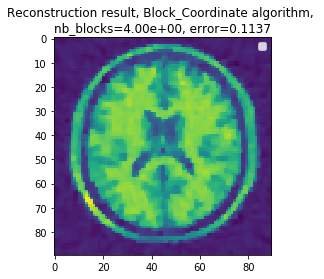

In [68]:
golden_section_search(BCMM, x, nb_blocks_range=[1,9], tol=1e-6, it_max=10, name='Block_Coordinate')

## 3.6 Comparison of the methods

First, compare the methods as they are right now :

----------------------------------------------------------------------  Function  1
----------------------------------------------------------------------  Function  2
----------------------------------------------------------------------  Function  3
----------------------------------------------------------------------  Function  4


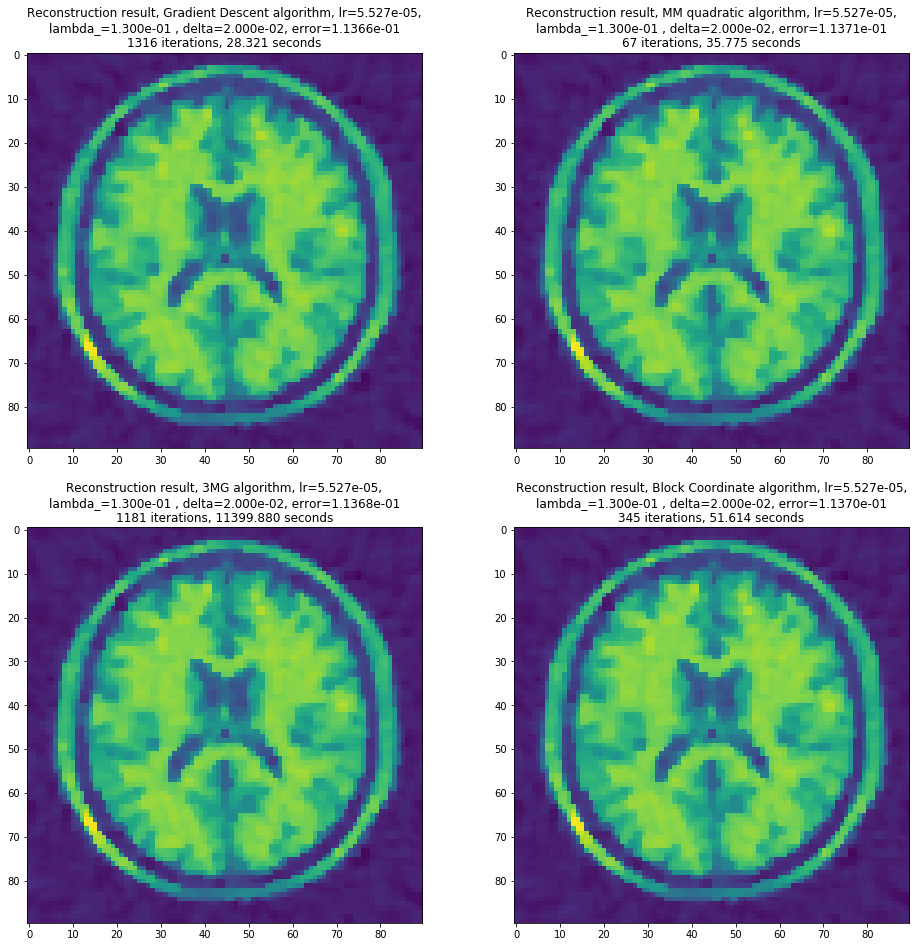

In [76]:
functions = [grad_desc, MM_quad, MMMG, BCMM]
functions_names = ['Gradient Descent', 'MM quadratic', '3MG', 'Block Coordinate']
history = [0 for _ in range(len(functions))]

fg, ax = plt.subplots(2,2,figsize=(16,16))
for index, function in enumerate(functions):
    print('-'*70,' Function ', index+1)
    beg = time.time()
    x_rec, _, history[index] = function(max_iter=np.inf, records=False)
    end = time.time()
    nb_itr = len(history[index])
    exec_time = end - beg
    rec_error = np.linalg.norm((x - x_rec).flatten(), ord=2)/np.linalg.norm(x.flatten(), ord=2)
    x_rec_view = x_rec.reshape((90,90), order='F')
    ax[index//2][index%2].imshow(x_rec_view)
    ax[index//2][index%2].set_title('Reconstruction result, {0} algorithm, lr={1:.3e},'.format(
                                                                        functions_names[index],learning_rate)
                 +'\nlambda_={0:.3e} , delta={1:.3e}, error={2:.4e}'.format(lambda_, delta, rec_error)
                 +'\n{0} iterations, {1:.3f} seconds'.format(nb_itr, exec_time))

>Basically the different methods yield exactly the same results. The main difference lies in the execution time and number of iterations. Note the incredibly high execution time of the 3MG algorithm, and thus, this one won't be plotted in the next question...

---

Then, let's compare the approaches using the gradient criterion defined as : $$\left\|\nabla f\left(x_{k}\right)\right\| \leq \sqrt{N} \times 10^{-4}$$

----------------------------------------------------------------------  Function  1
----------------------------------------------------------------------  Function  2
----------------------------------------------------------------------  Function  3


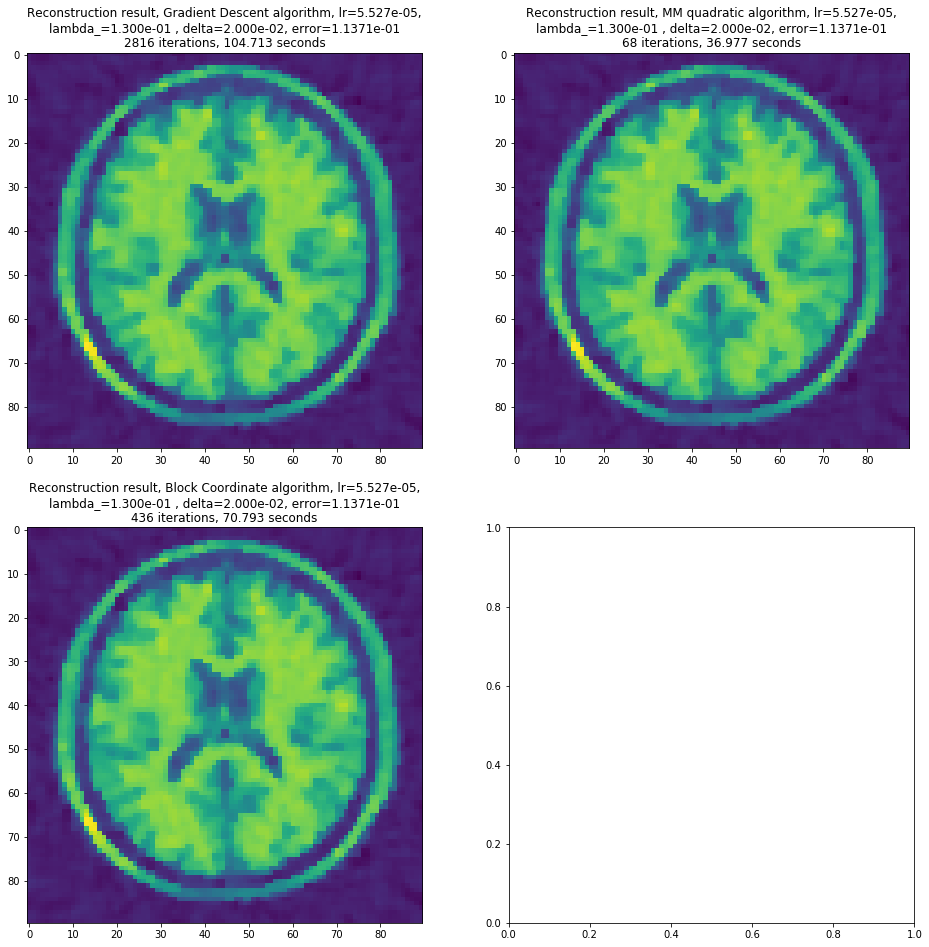

In [78]:
fg, ax = plt.subplots(2,2,figsize=(16,16))
functions = [grad_desc, MM_quad, BCMM]
functions_names = ['Gradient Descent', 'MM quadratic', 'Block Coordinate']
history = [0 for _ in range(len(functions))]
for index, function in enumerate(functions):
    print('-'*70,' Function ', index+1)
    beg = time.time()
    x_rec, _, history[index] = function(max_iter=np.inf, records=False, stopping='gradient')
    end = time.time()
    nb_itr = len(history[index])
    exec_time = end - beg
    rec_error = np.linalg.norm((x - x_rec).flatten(), ord=2)/np.linalg.norm(x.flatten(), ord=2)
    x_rec_view = x_rec.reshape((90,90), order='F')
    ax[index//2][index%2].imshow(x_rec_view)
    ax[index//2][index%2].set_title('Reconstruction result, {0} algorithm, lr={1:.3e},'.format(
                                                                        functions_names[index],learning_rate)
                 +'\nlambda_={0:.3e} , delta={1:.3e}, error={2:.4e}'.format(lambda_, delta, rec_error)
                 +'\n{0} iterations, {1:.3f} seconds'.format(nb_itr, exec_time))

Let's plot the decrease of $\left(f\left(x_{k}\right)\right)_{k \in \mathbb{N}}$ for each method :

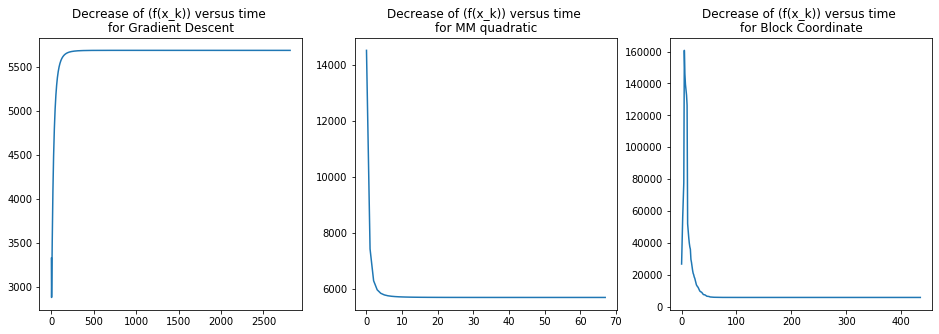

In [84]:
fg, ax = plt.subplots(1,3, figsize=(16,5))
for index, hist in enumerate(history):
    hist = np.array(hist)
    f_values = hist[:,1]
    t = [k for k in range(len(f_values))]
    ax[index].plot(t, f_values)#, label=functions_names[index])
    ax[index].set_title('Decrease of (f(x_k)) versus time \nfor {}'.format(functions_names[index]))
    #ax.legend()

>We visualize the comments we pointed out earlier about the increase of the function to minimize when using the gradient descent approach. Please note that the Block Coordinate method increases and then decreases : this could be explained by the fact that we only update a small part of the noisy signal.

---

Finally let's optimize the fastest method (MM quadratic) over $(\lambda, \delta)$ when minimizing the Signal to Noise Ratio defined as : $$\mathrm{SNR}=10 \log _{10}\left(\|\bar{x}\|^{2} /\|\bar{x}-\widehat{x}\|^{2}\right)$$

In [69]:
fg, ax = plt.subplots(1,1,figsize=(8,8))
grid_1 = [k*1e-2 for k in range(1,11)]
grid_2 = [1e-3, 3e-3, 5e-3, 7e-3, 1e-2, 2e-2, 4e-2, 6e-2, 8e-2, 1e-1]
best_error = np.inf
best_lbda = 0
best_dlt = 0
best_x_rec = 0
best_nb_itr = 0
best_exec_time = 0
for dlt in grid_1:
    for lbda in grid_2:
        beg = time.time()
        x_rec, _, history = MM_quad(lambda_=lbda, delta=dlt, max_iter=1000, records=False, error_type='SNR')
        end = time.time()
        nb_itr = len(history)
        exec_time = end - beg
        rec_error = np.linalg.norm((x - x_rec).flatten(), ord=2)/np.linalg.norm(x.flatten(), ord=2)
        if rec_error < best_error:
            best_lbda = lbda
            best_dlt = dlt
            best_error = rec_error
            best_x_rec = x_rec
            best_nb_itr = nb_itr
            best_exec_time = exec_time

        
x_rec_view = best_x_rec.reshape((90,90), order='F')
ax.imshow(x_rec_view)
ax.set_title('Reconstruction result, MM quadratic algorithm, lr={0:.3e},'.format(learning_rate)
             +'\nlambda_={0:.3e} , delta={1:.3e}, error={2:.4e}'.format(best_lbda, best_dlt, best_error)
             +'\n{0} iterations, {1:.3f} seconds'.format(best_nb_itr, best_exec_time))

Text(0.5, 1, 'Reconstruction result, MM quadratic algorithm, lr=5.527e-05,\nlambda_=4.000e-02 , delta=1.000e-02, error=1.1371e-01\n1000 iterations, 72.525 seconds')

Text(0.5, 1.0, 'Reconstruction result, MM quadratic algorithm, lr=5.527e-05,\nlambda_=4.000e-02 , delta=1.000e-02, error=1.1371e-01\n1000 iterations, 72.525 seconds')

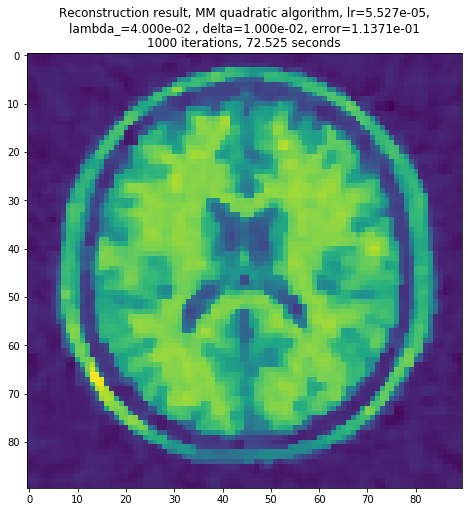

In [86]:
fg, ax = plt.subplots(1,1,figsize=(8,8))
x_rec_view = best_x_rec.reshape((90,90), order='F')
ax.imshow(x_rec_view)
ax.set_title('Reconstruction result, MM quadratic algorithm, lr={0:.3e},'.format(learning_rate)
             +'\nlambda_={0:.3e} , delta={1:.3e}, error={2:.4e}'.format(best_lbda, best_dlt, best_error)
             +'\n{0} iterations, {1:.3f} seconds'.format(best_nb_itr, best_exec_time))

>Surprisingly, λ and δ don't seem to have a huge impact on the reconstruction as the reconstruction error is exactly the same as before...